# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [574]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
import xgboost as xgb
import lightgbm as lgbm
from statsmodels.tsa.seasonal import seasonal_decompose
import pprint

In [575]:
df=pd.read_csv("taxi.csv",index_col=[0],parse_dates=[0])

In [576]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [577]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


## Análisis

In [578]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [579]:
df.index.is_monotonic_increasing


True

In [580]:
df.index.duplicated().sum()

0

In [581]:
df.index.min()

Timestamp('2018-03-01 00:00:00')

In [582]:
df.index.max()

Timestamp('2018-08-31 23:50:00')

<FONT COLOR=BLUE> LAS ORDENES VAN DESDE 0 A 119, DESDE EL  01-03-2018 AL 31-08-2018 , ESTAN ORDENADOS CADA 10 MINUTOS, POSTERIORMENTE SE REMUESTREARAN CADA 1 HR, NO HAY DATOS DUPLICADOS, NI AUSENTES </FONT>

In [583]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [584]:
df=df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


<AxesSubplot:xlabel='datetime'>

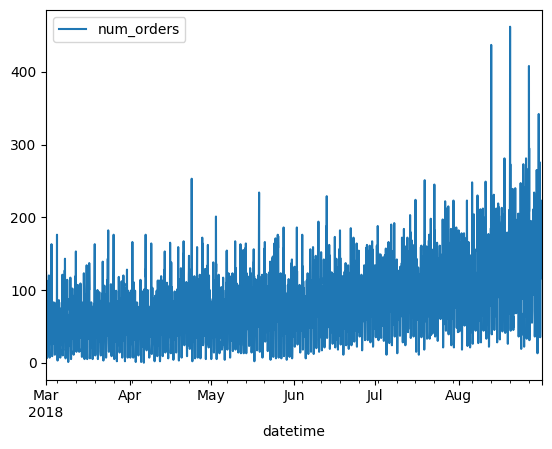

In [585]:
df.plot()

<AxesSubplot:xlabel='datetime'>

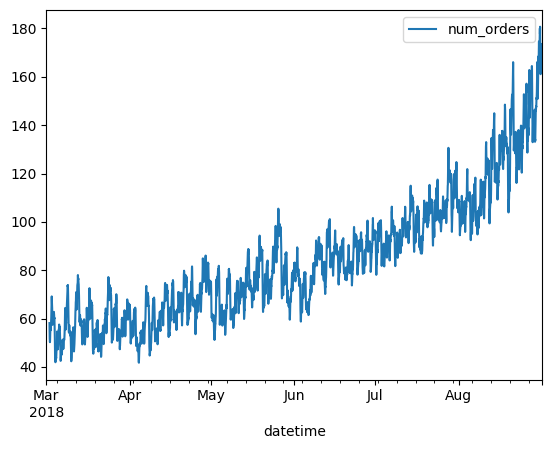

In [586]:
df.rolling(30).mean().plot()


Tendencias y estacionalidad

<AxesSubplot:xlabel='datetime'>

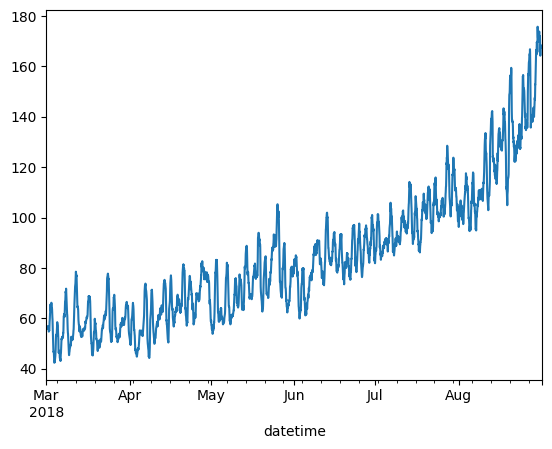

In [587]:
decomposed = seasonal_decompose(df)
decomposed.trend.plot()

<AxesSubplot:xlabel='datetime'>

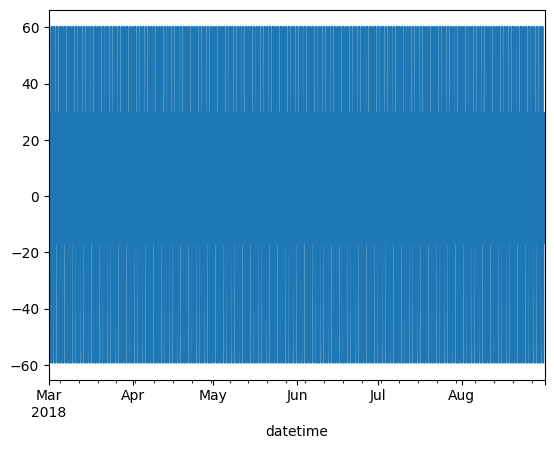

In [588]:
decomposed.seasonal.plot()

<AxesSubplot:xlabel='datetime'>

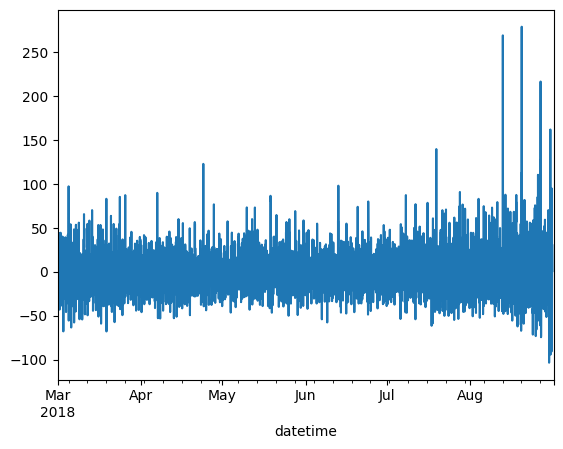

In [589]:
decomposed.resid.plot()

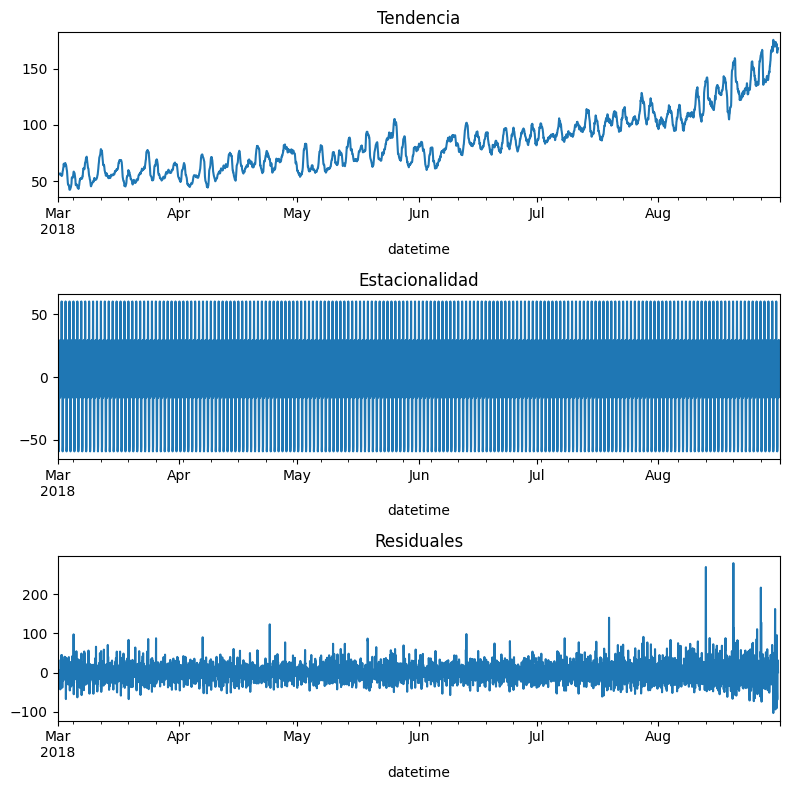

In [590]:
plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Tendencia')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Estacionalidad')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuales')
plt.tight_layout() 

<FONT COLOR=BLUE> La tendencia tiene un crecimiento su valor medio cambia 
Seasonality  tiene una repeticion muy marcada y no depende del tiempo </FONT>

<AxesSubplot:xlabel='datetime'>

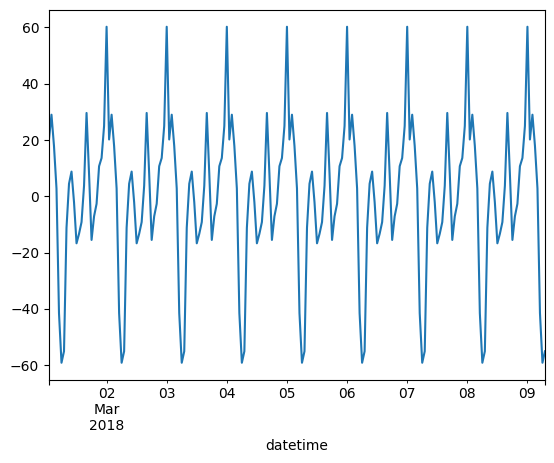

In [591]:
decomposed.seasonal[1:200].plot()

In [592]:
def make_features(df, max_lag):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_the_week'] = df.index.dayofweek   

    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
     
    #df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df['trending'] = seasonal_decompose(df['num_orders']).trend.shift()
    df['seasonal'] = seasonal_decompose(df['num_orders']).seasonal.shift()

In [593]:
make_features(df,55)
df

,num_orders,year,month,day,day_of_the_week,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,trending,seasonal
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.248112
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.177074
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.982743
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.885407
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,169.0,120.0,159.0,220.0,163.0,196.0,135.0,167.0,NaN,-15.527958
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,191.0,169.0,120.0,159.0,220.0,163.0,196.0,135.0,NaN,-7.124270
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,170.0,191.0,169.0,120.0,159.0,220.0,163.0,196.0,NaN,-2.696560


<FONT COLOR=BLUE> SE  UTILIZA LA FUNCION PARA PODER AGREGAR LAS CARACTERISTICAS JUNTO CON LAGS , COMO AÑO, MES , DIA, DIA DE LA SEMANA </FONT>

## Formación

In [594]:
train, test = train_test_split(df, shuffle=False,test_size=0.1 )
train=train.dropna()
test=test.dropna()
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']




# REGRESION LINEAL 

In [595]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
pred_train = model_lr.predict(features_train)
pred_test = model_lr.predict(features_test)
rmse_lr=np.sqrt(mean_squared_error(target_test, pred_test))
print("RMSE regresion lineal prueba:",rmse_lr)

RMSE regresion lineal prueba: 39.41621591341827


# RANDOM FOREST

In [596]:
n_estimators=150
model_rf = RandomForestRegressor(n_estimators,random_state=54321)
parametros = {
    'max_depth':[int(x) for x in np.linspace(10, 110, num = 5)],
    'min_samples_leaf': [2, 5, 10],
    'bootstrap': [True,False]
}

rf_gscv= GridSearchCV(model_rf, param_grid=parametros,scoring='neg_mean_squared_error', cv = 3, n_jobs=-1, verbose=2)
print(parametros)

{'max_depth': [10, 35, 60, 85, 110], 'min_samples_leaf': [2, 5, 10], 'bootstrap': [True, False]}


In [597]:

rf_gscv.fit(features_train, target_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[CV] END ...bootstrap=True, max_depth=10, min_samples_leaf=2; total time=   6.8s
[CV] END ...bootstrap=True, max_depth=10, min_samples_leaf=2; total time=   6.8s
[CV] END ...bootstrap=True, max_depth=10, min_samples_leaf=2; total time=   6.6s
[CV] END ...bootstrap=True, max_depth=10, min_samples_leaf=5; total time=   6.3s
[CV] END ...bootstrap=True, max_depth=10, min_samples_leaf=5; total time=   6.2s
[CV] END ...bootstrap=True, max_depth=10, min_samples_leaf=5; total time=   6.2s
[CV] END ..bootstrap=True, max_depth=10, min_samples_leaf=10; total time=   5.7s
[CV] END ..bootstrap=True, max_depth=10, min_samples_leaf=10; total time=   5.6s
[CV] END ..bootstrap=True, max_depth=10, min_samples_leaf=10; total time=   5.6s
[CV] END ...bootstrap=True, max_depth=35, min_samples_leaf=2; total time=   8.2s
[CV] END ...bootstrap=True, max_depth=35, min_samples_leaf=2; total time=   8.0s
[CV] END ...bootstrap=True, max_depth=35, min_sa

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(n_estimators=150,
                                             random_state=54321),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 35, 60, 85, 110],
                         'min_samples_leaf': [2, 5, 10]},
             scoring='neg_mean_squared_error', verbose=2)

In [598]:
print(f'Mejores hiperprámetros: {rf_gscv.best_params_}')

Mejores hiperprámetros: {'bootstrap': True, 'max_depth': 35, 'min_samples_leaf': 2}


In [600]:
test_rf_gscv = rf_gscv.predict(features_test)

In [601]:
rmse_rf=np.sqrt(mean_squared_error(target_test, test_rf_gscv))
print("RMSE para el conjunto de prueba:", rmse_rf)

RMSE para el conjunto de prueba: 38.75477545413064


 # LightGBM

In [644]:
lgbm_grid =lgbm.LGBMRegressor(random_state = 54321)
print('PARAMETROS:\n')
print(lgbm_grid.get_params())

PARAMETROS:

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 54321, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [649]:
boosting_type=['gbdt']
num_leaves= [int(x) for x in np.linspace(10, 70, num = 4)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 4)]
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 500, num = 4)]
objective= ['regression']
metric= ['mse']
learning_rate=[0.01]

param_grid = {'n_estimators': n_estimators,
              'boosting_type': boosting_type,
              'num_leaves': num_leaves,
              'max_depth': max_depth,
              'objective': objective,
              'metric' : metric,
              'learning_rate':learning_rate
              }

In [650]:
lgbm_grid_search = GridSearchCV(lgbm_grid, param_grid, cv = 5, verbose=2, n_jobs = -1,scoring='neg_mean_squared_error')

lgbm_grid_search.fit(features_train, target_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=1, num_leaves=10, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=1, num_leaves=10, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=1, num_leaves=10, objective=regression; total time=   0.0s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=1, num_leaves=10, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=1, num_leaves=10, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=1, num_leaves=30, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_dep

[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=333, num_leaves=70, objective=regression; total time=   4.3s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=333, num_leaves=70, objective=regression; total time=   4.7s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=333, num_leaves=70, objective=regression; total time=   5.0s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=333, num_leaves=70, objective=regression; total time=   4.5s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=333, num_leaves=70, objective=regression; total time=   3.9s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=500, num_leaves=10, objective=regression; total time=   1.8s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=10, metric=mse, n_estimators=500, num_leaves=10

[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=43, metric=mse, n_estimators=167, num_leaves=50, objective=regression; total time=   1.9s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=43, metric=mse, n_estimators=167, num_leaves=50, objective=regression; total time=   1.8s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=43, metric=mse, n_estimators=167, num_leaves=50, objective=regression; total time=   1.9s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=43, metric=mse, n_estimators=167, num_leaves=50, objective=regression; total time=   1.7s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=43, metric=mse, n_estimators=167, num_leaves=70, objective=regression; total time=   2.4s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=43, metric=mse, n_estimators=167, num_leaves=70, objective=regression; total time=   2.4s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=43, metric=mse, n_estimators=167, num_leaves=70

[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=1, num_leaves=30, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=1, num_leaves=50, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=1, num_leaves=50, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=1, num_leaves=50, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=1, num_leaves=50, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=1, num_leaves=50, objective=regression; total time=   0.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=1, num_leaves=70, objective=re

[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=500, num_leaves=30, objective=regression; total time=   3.8s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=500, num_leaves=30, objective=regression; total time=   3.5s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=500, num_leaves=30, objective=regression; total time=   3.6s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=500, num_leaves=30, objective=regression; total time=   3.7s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=500, num_leaves=30, objective=regression; total time=   3.3s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=500, num_leaves=50, objective=regression; total time=   5.6s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=76, metric=mse, n_estimators=500, num_leaves=50

[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=110, metric=mse, n_estimators=333, num_leaves=10, objective=regression; total time=   1.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=110, metric=mse, n_estimators=333, num_leaves=10, objective=regression; total time=   1.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=110, metric=mse, n_estimators=333, num_leaves=10, objective=regression; total time=   1.1s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=110, metric=mse, n_estimators=333, num_leaves=10, objective=regression; total time=   1.2s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=110, metric=mse, n_estimators=333, num_leaves=10, objective=regression; total time=   1.0s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=110, metric=mse, n_estimators=333, num_leaves=30, objective=regression; total time=   2.4s
[CV] END boosting_type=gbdt, learning_rate=0.01, max_depth=110, metric=mse, n_estimators=333, num_le

GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=54321), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'], 'learning_rate': [0.01],
                         'max_depth': [10, 43, 76, 110], 'metric': ['mse'],
                         'n_estimators': [1, 167, 333, 500],
                         'num_leaves': [10, 30, 50, 70],
                         'objective': ['regression']},
             scoring='neg_mean_squared_error', verbose=2)

In [654]:
lgbm_grid_search.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.01,
 'max_depth': 43,
 'metric': 'mse',
 'n_estimators': 500,
 'num_leaves': 30,
 'objective': 'regression'}

In [655]:
test_lgbm_grid_search= lgbm_grid_search.predict(features_test)

In [656]:
rmse_lgbm=np.sqrt(mean_squared_error(target_test, test_lgbm_grid_search))
print("RMSE para el conjunto de prueba LIGHTGBM:", rmse_lgbm)

RMSE para el conjunto de prueba LIGHTGBM: 38.12187294662482


 # CATBOOST

In [608]:
iterations_cat= [int(x) for x in np.linspace(start = 1, stop = 500, num = 4)]
model_cat_gscv = CatBoostRegressor(loss_function='RMSE',eval_metric='RMSE',random_seed=54321) 
print('PARAMETROS:\n')
print(model_cat_gscv.get_params())

PARAMETROS:

{'loss_function': 'RMSE', 'random_seed': 54321, 'eval_metric': 'RMSE'}


In [609]:
cat_grid = {'iterations':iterations_cat,
            'depth': [10],
            'l2_leaf_reg': [3],
            'learning_rate': [0.01],
            'rsm':[0.9]}

print(cat_grid)

{'iterations': [1, 167, 333, 500], 'depth': [10], 'l2_leaf_reg': [3], 'learning_rate': [0.01], 'rsm': [0.9]}


In [610]:
cat_gscv = GridSearchCV(model_cat_gscv,cat_grid, cv = 5, verbose=2, n_jobs = -1,scoring='neg_mean_squared_error')

cat_gscv.fit(features_train, target_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 38.7079592	total: 72.7ms	remaining: 0us
[CV] END depth=10, iterations=1, l2_leaf_reg=3, learning_rate=0.01, rsm=0.9; total time=   0.2s
0:	learn: 39.2375463	total: 73.4ms	remaining: 0us
[CV] END depth=10, iterations=1, l2_leaf_reg=3, learning_rate=0.01, rsm=0.9; total time=   0.2s
0:	learn: 39.4666423	total: 70.9ms	remaining: 0us
[CV] END depth=10, iterations=1, l2_leaf_reg=3, learning_rate=0.01, rsm=0.9; total time=   0.2s
0:	learn: 39.4505168	total: 70.4ms	remaining: 0us
[CV] END depth=10, iterations=1, l2_leaf_reg=3, learning_rate=0.01, rsm=0.9; total time=   0.2s
0:	learn: 34.0921849	total: 61.9ms	remaining: 0us
[CV] END depth=10, iterations=1, l2_leaf_reg=3, learning_rate=0.01, rsm=0.9; total time=   0.2s
0:	learn: 38.7079592	total: 79ms	remaining: 13.1s
1:	learn: 38.5224942	total: 154ms	remaining: 12.7s
2:	learn: 38.3423074	total: 231ms	remaining: 12.6s
3:	learn: 38.1575282	total: 310ms	remaining: 12.6s
4:	lear

143:	learn: 24.3366774	total: 11.1s	remaining: 1.78s
144:	learn: 24.2895276	total: 11.2s	remaining: 1.7s
145:	learn: 24.2397014	total: 11.3s	remaining: 1.63s
146:	learn: 24.1986375	total: 11.4s	remaining: 1.55s
147:	learn: 24.1569006	total: 11.5s	remaining: 1.47s
148:	learn: 24.1177740	total: 11.6s	remaining: 1.4s
149:	learn: 24.0682495	total: 11.7s	remaining: 1.32s
150:	learn: 24.0141978	total: 11.7s	remaining: 1.24s
151:	learn: 23.9652632	total: 11.8s	remaining: 1.16s
152:	learn: 23.9164800	total: 11.9s	remaining: 1.09s
153:	learn: 23.8761107	total: 12s	remaining: 1.01s
154:	learn: 23.8266913	total: 12s	remaining: 933ms
155:	learn: 23.7743684	total: 12.1s	remaining: 854ms
156:	learn: 23.7268225	total: 12.2s	remaining: 776ms
157:	learn: 23.6763048	total: 12.3s	remaining: 699ms
158:	learn: 23.6373805	total: 12.3s	remaining: 621ms
159:	learn: 23.5939327	total: 12.4s	remaining: 543ms
160:	learn: 23.5552488	total: 12.5s	remaining: 466ms
161:	learn: 23.5138749	total: 12.6s	remaining: 389ms

132:	learn: 24.7928275	total: 10.4s	remaining: 2.66s
133:	learn: 24.7432831	total: 10.5s	remaining: 2.58s
134:	learn: 24.6898182	total: 10.6s	remaining: 2.5s
135:	learn: 24.6309388	total: 10.6s	remaining: 2.42s
136:	learn: 24.5731429	total: 10.7s	remaining: 2.35s
137:	learn: 24.5201814	total: 10.8s	remaining: 2.27s
138:	learn: 24.4686568	total: 10.9s	remaining: 2.19s
139:	learn: 24.4157407	total: 11s	remaining: 2.11s
140:	learn: 24.3611890	total: 11s	remaining: 2.04s
141:	learn: 24.3117403	total: 11.1s	remaining: 1.96s
142:	learn: 24.2575720	total: 11.2s	remaining: 1.88s
143:	learn: 24.2096136	total: 11.3s	remaining: 1.8s
144:	learn: 24.1572011	total: 11.3s	remaining: 1.72s
145:	learn: 24.1026434	total: 11.4s	remaining: 1.64s
146:	learn: 24.0533355	total: 11.5s	remaining: 1.56s
147:	learn: 24.0010480	total: 11.6s	remaining: 1.49s
148:	learn: 23.9595737	total: 11.7s	remaining: 1.41s
149:	learn: 23.9087009	total: 11.7s	remaining: 1.33s
150:	learn: 23.8576461	total: 11.8s	remaining: 1.25s

123:	learn: 25.1122073	total: 9.35s	remaining: 3.24s
124:	learn: 25.0499927	total: 9.42s	remaining: 3.17s
125:	learn: 24.9929802	total: 9.49s	remaining: 3.09s
126:	learn: 24.9330391	total: 9.57s	remaining: 3.01s
127:	learn: 24.8766713	total: 9.64s	remaining: 2.94s
128:	learn: 24.8242834	total: 9.72s	remaining: 2.86s
129:	learn: 24.7581754	total: 9.79s	remaining: 2.79s
130:	learn: 24.6976328	total: 9.87s	remaining: 2.71s
131:	learn: 24.6350281	total: 9.94s	remaining: 2.63s
132:	learn: 24.5802368	total: 10s	remaining: 2.56s
133:	learn: 24.5287935	total: 10.1s	remaining: 2.49s
134:	learn: 24.4675991	total: 10.2s	remaining: 2.41s
135:	learn: 24.4065011	total: 10.3s	remaining: 2.34s
136:	learn: 24.3575637	total: 10.3s	remaining: 2.26s
137:	learn: 24.3037250	total: 10.4s	remaining: 2.19s
138:	learn: 24.2502184	total: 10.5s	remaining: 2.11s
139:	learn: 24.1988146	total: 10.6s	remaining: 2.04s
140:	learn: 24.1509203	total: 10.6s	remaining: 1.96s
141:	learn: 24.1001578	total: 10.7s	remaining: 1

114:	learn: 25.4088386	total: 8.66s	remaining: 3.92s
115:	learn: 25.3460815	total: 8.74s	remaining: 3.84s
116:	learn: 25.2794307	total: 8.81s	remaining: 3.77s
117:	learn: 25.2141882	total: 8.89s	remaining: 3.69s
118:	learn: 25.1555128	total: 8.97s	remaining: 3.62s
119:	learn: 25.0937687	total: 9.04s	remaining: 3.54s
120:	learn: 25.0271867	total: 9.12s	remaining: 3.47s
121:	learn: 24.9647561	total: 9.19s	remaining: 3.39s
122:	learn: 24.9038457	total: 9.27s	remaining: 3.31s
123:	learn: 24.8435766	total: 9.34s	remaining: 3.24s
124:	learn: 24.7800650	total: 9.42s	remaining: 3.17s
125:	learn: 24.7231430	total: 9.5s	remaining: 3.09s
126:	learn: 24.6582999	total: 9.57s	remaining: 3.02s
127:	learn: 24.6015318	total: 9.65s	remaining: 2.94s
128:	learn: 24.5474207	total: 9.72s	remaining: 2.86s
129:	learn: 24.4877268	total: 9.8s	remaining: 2.79s
130:	learn: 24.4271138	total: 9.87s	remaining: 2.71s
131:	learn: 24.3656642	total: 9.95s	remaining: 2.64s
132:	learn: 24.3135974	total: 10s	remaining: 2.5

106:	learn: 22.9331390	total: 6.98s	remaining: 3.91s
107:	learn: 22.8812893	total: 7.04s	remaining: 3.85s
108:	learn: 22.8214104	total: 7.11s	remaining: 3.78s
109:	learn: 22.7587334	total: 7.17s	remaining: 3.71s
110:	learn: 22.6982976	total: 7.24s	remaining: 3.65s
111:	learn: 22.6421059	total: 7.3s	remaining: 3.59s
112:	learn: 22.5809031	total: 7.37s	remaining: 3.52s
113:	learn: 22.5245598	total: 7.43s	remaining: 3.46s
114:	learn: 22.4644498	total: 7.5s	remaining: 3.39s
115:	learn: 22.4078218	total: 7.56s	remaining: 3.33s
116:	learn: 22.3573543	total: 7.63s	remaining: 3.26s
117:	learn: 22.3009016	total: 7.7s	remaining: 3.2s
118:	learn: 22.2445183	total: 7.77s	remaining: 3.13s
119:	learn: 22.1865286	total: 7.83s	remaining: 3.07s
120:	learn: 22.1285488	total: 7.9s	remaining: 3s
121:	learn: 22.0728174	total: 7.96s	remaining: 2.94s
122:	learn: 22.0157672	total: 8.03s	remaining: 2.87s
123:	learn: 21.9553724	total: 8.09s	remaining: 2.81s
124:	learn: 21.9060976	total: 8.16s	remaining: 2.74s
1

96:	learn: 27.2012059	total: 7.47s	remaining: 18.2s
97:	learn: 27.1280488	total: 7.54s	remaining: 18.1s
98:	learn: 27.0528513	total: 7.62s	remaining: 18s
99:	learn: 26.9753952	total: 7.69s	remaining: 17.9s
100:	learn: 26.9127728	total: 7.77s	remaining: 17.9s
101:	learn: 26.8401121	total: 7.84s	remaining: 17.8s
102:	learn: 26.7687626	total: 7.92s	remaining: 17.7s
103:	learn: 26.6965280	total: 8s	remaining: 17.6s
104:	learn: 26.6262057	total: 8.08s	remaining: 17.5s
105:	learn: 26.5571015	total: 8.16s	remaining: 17.5s
106:	learn: 26.4896598	total: 8.24s	remaining: 17.4s
107:	learn: 26.4239035	total: 8.31s	remaining: 17.3s
108:	learn: 26.3592176	total: 8.39s	remaining: 17.2s
109:	learn: 26.2899206	total: 8.46s	remaining: 17.1s
110:	learn: 26.2187441	total: 8.54s	remaining: 17.1s
111:	learn: 26.1504333	total: 8.61s	remaining: 17s
112:	learn: 26.0882864	total: 8.69s	remaining: 16.9s
113:	learn: 26.0288066	total: 8.77s	remaining: 16.8s
114:	learn: 25.9702633	total: 8.84s	remaining: 16.8s
115:

252:	learn: 20.5371534	total: 19.5s	remaining: 6.15s
253:	learn: 20.5117616	total: 19.5s	remaining: 6.08s
254:	learn: 20.4859904	total: 19.6s	remaining: 6s
255:	learn: 20.4621802	total: 19.7s	remaining: 5.92s
256:	learn: 20.4398043	total: 19.8s	remaining: 5.84s
257:	learn: 20.4081053	total: 19.8s	remaining: 5.77s
258:	learn: 20.3877849	total: 19.9s	remaining: 5.69s
259:	learn: 20.3660436	total: 20s	remaining: 5.61s
260:	learn: 20.3474042	total: 20.1s	remaining: 5.53s
261:	learn: 20.3199429	total: 20.1s	remaining: 5.46s
262:	learn: 20.2953687	total: 20.2s	remaining: 5.38s
263:	learn: 20.2747572	total: 20.3s	remaining: 5.3s
264:	learn: 20.2467342	total: 20.4s	remaining: 5.22s
265:	learn: 20.2234491	total: 20.4s	remaining: 5.14s
266:	learn: 20.1896934	total: 20.5s	remaining: 5.07s
267:	learn: 20.1714351	total: 20.6s	remaining: 4.99s
268:	learn: 20.1483286	total: 20.7s	remaining: 4.92s
269:	learn: 20.1195801	total: 20.7s	remaining: 4.84s
270:	learn: 20.0961588	total: 20.8s	remaining: 4.76s

76:	learn: 28.8480159	total: 5.89s	remaining: 19.6s
77:	learn: 28.7526450	total: 5.97s	remaining: 19.5s
78:	learn: 28.6596748	total: 6.04s	remaining: 19.4s
79:	learn: 28.5701384	total: 6.12s	remaining: 19.4s
80:	learn: 28.4732236	total: 6.21s	remaining: 19.3s
81:	learn: 28.3865326	total: 6.28s	remaining: 19.2s
82:	learn: 28.3031908	total: 6.36s	remaining: 19.1s
83:	learn: 28.2168432	total: 6.43s	remaining: 19.1s
84:	learn: 28.1351439	total: 6.51s	remaining: 19s
85:	learn: 28.0495657	total: 6.58s	remaining: 18.9s
86:	learn: 27.9690170	total: 6.66s	remaining: 18.8s
87:	learn: 27.8867546	total: 6.73s	remaining: 18.7s
88:	learn: 27.7976588	total: 6.8s	remaining: 18.7s
89:	learn: 27.7162631	total: 6.89s	remaining: 18.6s
90:	learn: 27.6278424	total: 6.96s	remaining: 18.5s
91:	learn: 27.5492981	total: 7.04s	remaining: 18.4s
92:	learn: 27.4709469	total: 7.12s	remaining: 18.4s
93:	learn: 27.3963232	total: 7.2s	remaining: 18.3s
94:	learn: 27.3114174	total: 7.28s	remaining: 18.2s
95:	learn: 27.23

232:	learn: 20.8996624	total: 17.9s	remaining: 7.68s
233:	learn: 20.8697039	total: 18s	remaining: 7.61s
234:	learn: 20.8483374	total: 18.1s	remaining: 7.53s
235:	learn: 20.8216612	total: 18.1s	remaining: 7.45s
236:	learn: 20.7957812	total: 18.2s	remaining: 7.37s
237:	learn: 20.7679082	total: 18.3s	remaining: 7.3s
238:	learn: 20.7370840	total: 18.4s	remaining: 7.22s
239:	learn: 20.7126921	total: 18.4s	remaining: 7.14s
240:	learn: 20.6898217	total: 18.5s	remaining: 7.07s
241:	learn: 20.6679878	total: 18.6s	remaining: 6.99s
242:	learn: 20.6411967	total: 18.7s	remaining: 6.91s
243:	learn: 20.6143629	total: 18.7s	remaining: 6.83s
244:	learn: 20.5880864	total: 18.8s	remaining: 6.76s
245:	learn: 20.5576862	total: 18.9s	remaining: 6.68s
246:	learn: 20.5291733	total: 19s	remaining: 6.6s
247:	learn: 20.4977283	total: 19s	remaining: 6.53s
248:	learn: 20.4711719	total: 19.1s	remaining: 6.45s
249:	learn: 20.4462864	total: 19.2s	remaining: 6.38s
250:	learn: 20.4206898	total: 19.3s	remaining: 6.3s
25

57:	learn: 30.7167782	total: 4.48s	remaining: 21.2s
58:	learn: 30.6156362	total: 4.55s	remaining: 21.1s
59:	learn: 30.4914012	total: 4.62s	remaining: 21s
60:	learn: 30.3772364	total: 4.7s	remaining: 21s
61:	learn: 30.2579114	total: 4.78s	remaining: 20.9s
62:	learn: 30.1436437	total: 4.85s	remaining: 20.8s
63:	learn: 30.0442576	total: 4.92s	remaining: 20.7s
64:	learn: 29.9276804	total: 5s	remaining: 20.6s
65:	learn: 29.8207838	total: 5.07s	remaining: 20.5s
66:	learn: 29.7121596	total: 5.14s	remaining: 20.4s
67:	learn: 29.6054791	total: 5.22s	remaining: 20.3s
68:	learn: 29.5053058	total: 5.3s	remaining: 20.3s
69:	learn: 29.4026540	total: 5.38s	remaining: 20.2s
70:	learn: 29.3026792	total: 5.45s	remaining: 20.1s
71:	learn: 29.1960948	total: 5.52s	remaining: 20s
72:	learn: 29.1016528	total: 5.61s	remaining: 20s
73:	learn: 29.0017217	total: 5.68s	remaining: 19.9s
74:	learn: 28.9030836	total: 5.76s	remaining: 19.8s
75:	learn: 28.8041623	total: 5.83s	remaining: 19.7s
76:	learn: 28.7032165	tot

216:	learn: 21.1077965	total: 16.6s	remaining: 8.89s
217:	learn: 21.0753516	total: 16.7s	remaining: 8.81s
218:	learn: 21.0495296	total: 16.8s	remaining: 8.74s
219:	learn: 21.0219034	total: 16.9s	remaining: 8.66s
220:	learn: 20.9929585	total: 16.9s	remaining: 8.59s
221:	learn: 20.9635054	total: 17s	remaining: 8.51s
222:	learn: 20.9305125	total: 17.1s	remaining: 8.43s
223:	learn: 20.9008957	total: 17.2s	remaining: 8.35s
224:	learn: 20.8697896	total: 17.2s	remaining: 8.27s
225:	learn: 20.8379650	total: 17.3s	remaining: 8.2s
226:	learn: 20.8083932	total: 17.4s	remaining: 8.13s
227:	learn: 20.7762643	total: 17.5s	remaining: 8.05s
228:	learn: 20.7514595	total: 17.6s	remaining: 7.97s
229:	learn: 20.7222802	total: 17.6s	remaining: 7.9s
230:	learn: 20.6997995	total: 17.7s	remaining: 7.82s
231:	learn: 20.6717727	total: 17.8s	remaining: 7.74s
232:	learn: 20.6438505	total: 17.9s	remaining: 7.67s
233:	learn: 20.6120593	total: 17.9s	remaining: 7.59s
234:	learn: 20.5840333	total: 18s	remaining: 7.52s

38:	learn: 32.9398979	total: 3.16s	remaining: 23.8s
39:	learn: 32.8037170	total: 3.25s	remaining: 23.8s
40:	learn: 32.6644597	total: 3.33s	remaining: 23.8s
41:	learn: 32.5369846	total: 3.44s	remaining: 23.9s
42:	learn: 32.3891527	total: 3.52s	remaining: 23.8s
43:	learn: 32.2453879	total: 3.6s	remaining: 23.7s
44:	learn: 32.1105153	total: 3.69s	remaining: 23.6s
45:	learn: 31.9702330	total: 3.78s	remaining: 23.6s
46:	learn: 31.8408603	total: 3.86s	remaining: 23.5s
47:	learn: 31.7023398	total: 3.93s	remaining: 23.4s
48:	learn: 31.5689531	total: 4.01s	remaining: 23.3s
49:	learn: 31.4472567	total: 4.09s	remaining: 23.1s
50:	learn: 31.3332525	total: 4.16s	remaining: 23s
51:	learn: 31.2116175	total: 4.24s	remaining: 22.9s
52:	learn: 31.0895380	total: 4.3s	remaining: 22.7s
53:	learn: 30.9664077	total: 4.37s	remaining: 22.6s
54:	learn: 30.8521058	total: 4.45s	remaining: 22.5s
55:	learn: 30.7346747	total: 4.52s	remaining: 22.4s
56:	learn: 30.6104635	total: 4.61s	remaining: 22.3s
57:	learn: 30.50

197:	learn: 21.4424558	total: 15.5s	remaining: 10.6s
198:	learn: 21.4068240	total: 15.6s	remaining: 10.5s
199:	learn: 21.3735684	total: 15.6s	remaining: 10.4s
200:	learn: 21.3381774	total: 15.7s	remaining: 10.3s
201:	learn: 21.3040600	total: 15.8s	remaining: 10.2s
202:	learn: 21.2644291	total: 15.9s	remaining: 10.2s
203:	learn: 21.2316174	total: 15.9s	remaining: 10.1s
204:	learn: 21.1993857	total: 16s	remaining: 10s
205:	learn: 21.1637361	total: 16.1s	remaining: 9.92s
206:	learn: 21.1320366	total: 16.2s	remaining: 9.84s
207:	learn: 21.0959947	total: 16.2s	remaining: 9.76s
208:	learn: 21.0663882	total: 16.3s	remaining: 9.68s
209:	learn: 21.0326352	total: 16.4s	remaining: 9.6s
210:	learn: 21.0003029	total: 16.5s	remaining: 9.52s
211:	learn: 20.9658510	total: 16.5s	remaining: 9.44s
212:	learn: 20.9332843	total: 16.6s	remaining: 9.36s
213:	learn: 20.8987338	total: 16.7s	remaining: 9.29s
214:	learn: 20.8654000	total: 16.8s	remaining: 9.21s
215:	learn: 20.8384280	total: 16.8s	remaining: 9.13

21:	learn: 30.9146652	total: 1.44s	remaining: 20.3s
22:	learn: 30.7768214	total: 1.51s	remaining: 20.4s
23:	learn: 30.6365926	total: 1.58s	remaining: 20.3s
24:	learn: 30.5052282	total: 1.64s	remaining: 20.2s
25:	learn: 30.3690371	total: 1.7s	remaining: 20.1s
26:	learn: 30.2490983	total: 1.77s	remaining: 20.1s
27:	learn: 30.1177603	total: 1.84s	remaining: 20s
28:	learn: 29.9815364	total: 1.9s	remaining: 20s
29:	learn: 29.8533642	total: 1.97s	remaining: 19.9s
30:	learn: 29.7226302	total: 2.04s	remaining: 19.8s
31:	learn: 29.6164781	total: 2.1s	remaining: 19.7s
32:	learn: 29.4876599	total: 2.17s	remaining: 19.7s
33:	learn: 29.3631871	total: 2.23s	remaining: 19.6s
34:	learn: 29.2377497	total: 2.29s	remaining: 19.5s
35:	learn: 29.1083851	total: 2.36s	remaining: 19.5s
36:	learn: 28.9942400	total: 2.43s	remaining: 19.4s
37:	learn: 28.8771641	total: 2.5s	remaining: 19.4s
38:	learn: 28.7600012	total: 2.56s	remaining: 19.3s
39:	learn: 28.6400605	total: 2.62s	remaining: 19.2s
40:	learn: 28.526137

182:	learn: 19.5449361	total: 12s	remaining: 9.8s
183:	learn: 19.5110992	total: 12s	remaining: 9.73s
184:	learn: 19.4791206	total: 12.1s	remaining: 9.67s
185:	learn: 19.4481506	total: 12.1s	remaining: 9.6s
186:	learn: 19.4122067	total: 12.2s	remaining: 9.54s
187:	learn: 19.3792779	total: 12.3s	remaining: 9.48s
188:	learn: 19.3494735	total: 12.4s	remaining: 9.42s
189:	learn: 19.3180737	total: 12.4s	remaining: 9.35s
190:	learn: 19.2865509	total: 12.5s	remaining: 9.29s
191:	learn: 19.2562078	total: 12.6s	remaining: 9.22s
192:	learn: 19.2266602	total: 12.6s	remaining: 9.16s
193:	learn: 19.2005664	total: 12.7s	remaining: 9.09s
194:	learn: 19.1667815	total: 12.8s	remaining: 9.03s
195:	learn: 19.1375986	total: 12.8s	remaining: 8.96s
196:	learn: 19.1073585	total: 12.9s	remaining: 8.89s
197:	learn: 19.0758164	total: 12.9s	remaining: 8.83s
198:	learn: 19.0458122	total: 13s	remaining: 8.76s
199:	learn: 19.0161200	total: 13.1s	remaining: 8.7s
200:	learn: 18.9889291	total: 13.1s	remaining: 8.63s
20

4:	learn: 37.9807342	total: 409ms	remaining: 40.5s
5:	learn: 37.8067326	total: 490ms	remaining: 40.3s
6:	learn: 37.6374154	total: 568ms	remaining: 40s
7:	learn: 37.4568820	total: 645ms	remaining: 39.6s
8:	learn: 37.2749050	total: 730ms	remaining: 39.8s
9:	learn: 37.1150425	total: 806ms	remaining: 39.5s
10:	learn: 36.9497311	total: 893ms	remaining: 39.7s
11:	learn: 36.7814932	total: 973ms	remaining: 39.5s
12:	learn: 36.6259556	total: 1.05s	remaining: 39.4s
13:	learn: 36.4538529	total: 1.13s	remaining: 39.3s
14:	learn: 36.2892730	total: 1.21s	remaining: 39.1s
15:	learn: 36.1464897	total: 1.28s	remaining: 38.8s
16:	learn: 35.9809545	total: 1.37s	remaining: 38.9s
17:	learn: 35.8231655	total: 1.46s	remaining: 39.1s
18:	learn: 35.6750958	total: 1.57s	remaining: 39.7s
19:	learn: 35.5251234	total: 1.65s	remaining: 39.6s
20:	learn: 35.3742492	total: 1.73s	remaining: 39.4s
21:	learn: 35.2186021	total: 1.81s	remaining: 39.4s
22:	learn: 35.0773933	total: 1.9s	remaining: 39.4s
23:	learn: 34.9367135

163:	learn: 23.4263750	total: 12.7s	remaining: 26.1s
164:	learn: 23.3862404	total: 12.8s	remaining: 26s
165:	learn: 23.3478329	total: 12.9s	remaining: 25.9s
166:	learn: 23.3095213	total: 13s	remaining: 25.9s
167:	learn: 23.2676187	total: 13s	remaining: 25.8s
168:	learn: 23.2253108	total: 13.1s	remaining: 25.7s
169:	learn: 23.1861361	total: 13.2s	remaining: 25.6s
170:	learn: 23.1365061	total: 13.3s	remaining: 25.5s
171:	learn: 23.0970362	total: 13.3s	remaining: 25.5s
172:	learn: 23.0623066	total: 13.4s	remaining: 25.4s
173:	learn: 23.0237741	total: 13.5s	remaining: 25.3s
174:	learn: 22.9896372	total: 13.6s	remaining: 25.2s
175:	learn: 22.9482227	total: 13.6s	remaining: 25.1s
176:	learn: 22.9154774	total: 13.7s	remaining: 25s
177:	learn: 22.8721648	total: 13.8s	remaining: 25s
178:	learn: 22.8352957	total: 13.9s	remaining: 24.9s
179:	learn: 22.7972062	total: 14s	remaining: 24.8s
180:	learn: 22.7605840	total: 14s	remaining: 24.8s
181:	learn: 22.7293698	total: 14.1s	remaining: 24.7s
182:	le

319:	learn: 19.2170214	total: 24.8s	remaining: 13.9s
320:	learn: 19.1992230	total: 24.9s	remaining: 13.9s
321:	learn: 19.1845754	total: 24.9s	remaining: 13.8s
322:	learn: 19.1671019	total: 25s	remaining: 13.7s
323:	learn: 19.1645919	total: 25.1s	remaining: 13.6s
324:	learn: 19.1470702	total: 25.2s	remaining: 13.6s
325:	learn: 19.1314306	total: 25.3s	remaining: 13.5s
326:	learn: 19.1127569	total: 25.3s	remaining: 13.4s
327:	learn: 19.0921586	total: 25.4s	remaining: 13.3s
328:	learn: 19.0741166	total: 25.5s	remaining: 13.2s
329:	learn: 19.0549017	total: 25.6s	remaining: 13.2s
330:	learn: 19.0373152	total: 25.6s	remaining: 13.1s
331:	learn: 19.0185017	total: 25.7s	remaining: 13s
332:	learn: 18.9989860	total: 25.8s	remaining: 12.9s
333:	learn: 18.9840995	total: 25.9s	remaining: 12.9s
334:	learn: 18.9711982	total: 25.9s	remaining: 12.8s
335:	learn: 18.9655252	total: 26s	remaining: 12.7s
336:	learn: 18.9600808	total: 26.1s	remaining: 12.6s
337:	learn: 18.9416919	total: 26.2s	remaining: 12.6s

477:	learn: 17.3590967	total: 36.9s	remaining: 1.7s
478:	learn: 17.3492721	total: 37s	remaining: 1.62s
479:	learn: 17.3464224	total: 37.1s	remaining: 1.54s
480:	learn: 17.3374210	total: 37.1s	remaining: 1.47s
481:	learn: 17.3255469	total: 37.2s	remaining: 1.39s
482:	learn: 17.3156189	total: 37.3s	remaining: 1.31s
483:	learn: 17.3011720	total: 37.4s	remaining: 1.24s
484:	learn: 17.2880548	total: 37.5s	remaining: 1.16s
485:	learn: 17.2863881	total: 37.5s	remaining: 1.08s
486:	learn: 17.2764939	total: 37.6s	remaining: 1s
487:	learn: 17.2650328	total: 37.7s	remaining: 927ms
488:	learn: 17.2564883	total: 37.8s	remaining: 849ms
489:	learn: 17.2468302	total: 37.8s	remaining: 772ms
490:	learn: 17.2367376	total: 37.9s	remaining: 695ms
491:	learn: 17.2258100	total: 38s	remaining: 618ms
492:	learn: 17.2122346	total: 38.1s	remaining: 540ms
493:	learn: 17.2019841	total: 38.1s	remaining: 463ms
494:	learn: 17.1881352	total: 38.2s	remaining: 386ms
495:	learn: 17.1827186	total: 38.3s	remaining: 309ms
4

135:	learn: 24.6309388	total: 10.4s	remaining: 27.8s
136:	learn: 24.5731429	total: 10.5s	remaining: 27.7s
137:	learn: 24.5201814	total: 10.5s	remaining: 27.6s
138:	learn: 24.4686568	total: 10.6s	remaining: 27.5s
139:	learn: 24.4157407	total: 10.7s	remaining: 27.5s
140:	learn: 24.3611890	total: 10.8s	remaining: 27.4s
141:	learn: 24.3117403	total: 10.8s	remaining: 27.3s
142:	learn: 24.2575720	total: 10.9s	remaining: 27.3s
143:	learn: 24.2096136	total: 11s	remaining: 27.2s
144:	learn: 24.1572011	total: 11.1s	remaining: 27.1s
145:	learn: 24.1026434	total: 11.1s	remaining: 27s
146:	learn: 24.0533355	total: 11.2s	remaining: 26.9s
147:	learn: 24.0010480	total: 11.3s	remaining: 26.8s
148:	learn: 23.9595737	total: 11.4s	remaining: 26.8s
149:	learn: 23.9087009	total: 11.4s	remaining: 26.7s
150:	learn: 23.8576461	total: 11.5s	remaining: 26.6s
151:	learn: 23.8120221	total: 11.6s	remaining: 26.5s
152:	learn: 23.7674568	total: 11.7s	remaining: 26.4s
153:	learn: 23.7252802	total: 11.7s	remaining: 26.

291:	learn: 19.5432885	total: 22.3s	remaining: 15.9s
292:	learn: 19.5253651	total: 22.4s	remaining: 15.8s
293:	learn: 19.5091241	total: 22.5s	remaining: 15.7s
294:	learn: 19.4880768	total: 22.5s	remaining: 15.7s
295:	learn: 19.4660318	total: 22.6s	remaining: 15.6s
296:	learn: 19.4444511	total: 22.7s	remaining: 15.5s
297:	learn: 19.4282043	total: 22.8s	remaining: 15.4s
298:	learn: 19.4123577	total: 22.9s	remaining: 15.4s
299:	learn: 19.3947132	total: 22.9s	remaining: 15.3s
300:	learn: 19.3739017	total: 23s	remaining: 15.2s
301:	learn: 19.3569801	total: 23.1s	remaining: 15.1s
302:	learn: 19.3501134	total: 23.2s	remaining: 15.1s
303:	learn: 19.3336925	total: 23.2s	remaining: 15s
304:	learn: 19.3180214	total: 23.3s	remaining: 14.9s
305:	learn: 19.3056086	total: 23.4s	remaining: 14.8s
306:	learn: 19.2796857	total: 23.5s	remaining: 14.8s
307:	learn: 19.2704381	total: 23.5s	remaining: 14.7s
308:	learn: 19.2660605	total: 23.6s	remaining: 14.6s
309:	learn: 19.2547988	total: 23.7s	remaining: 14.

448:	learn: 17.5658088	total: 34.3s	remaining: 3.9s
449:	learn: 17.5628031	total: 34.4s	remaining: 3.82s
450:	learn: 17.5552366	total: 34.5s	remaining: 3.75s
451:	learn: 17.5529693	total: 34.6s	remaining: 3.67s
452:	learn: 17.5468329	total: 34.6s	remaining: 3.59s
453:	learn: 17.5323454	total: 34.7s	remaining: 3.52s
454:	learn: 17.5236001	total: 34.8s	remaining: 3.44s
455:	learn: 17.5166298	total: 34.9s	remaining: 3.36s
456:	learn: 17.5084164	total: 34.9s	remaining: 3.29s
457:	learn: 17.5067966	total: 35s	remaining: 3.21s
458:	learn: 17.5005866	total: 35.1s	remaining: 3.13s
459:	learn: 17.4949010	total: 35.2s	remaining: 3.06s
460:	learn: 17.4904170	total: 35.2s	remaining: 2.98s
461:	learn: 17.4787945	total: 35.3s	remaining: 2.9s
462:	learn: 17.4713021	total: 35.4s	remaining: 2.83s
463:	learn: 17.4553591	total: 35.5s	remaining: 2.75s
464:	learn: 17.4514245	total: 35.5s	remaining: 2.67s
465:	learn: 17.4395292	total: 35.6s	remaining: 2.6s
466:	learn: 17.4266915	total: 35.7s	remaining: 2.52

106:	learn: 26.2321272	total: 8.15s	remaining: 29.9s
107:	learn: 26.1558336	total: 8.22s	remaining: 29.8s
108:	learn: 26.0879593	total: 8.3s	remaining: 29.8s
109:	learn: 26.0183554	total: 8.37s	remaining: 29.7s
110:	learn: 25.9501824	total: 8.45s	remaining: 29.6s
111:	learn: 25.8787017	total: 8.53s	remaining: 29.5s
112:	learn: 25.8155414	total: 8.61s	remaining: 29.5s
113:	learn: 25.7517081	total: 8.68s	remaining: 29.4s
114:	learn: 25.6893865	total: 8.76s	remaining: 29.3s
115:	learn: 25.6308131	total: 8.83s	remaining: 29.2s
116:	learn: 25.5570840	total: 8.91s	remaining: 29.2s
117:	learn: 25.4869931	total: 8.98s	remaining: 29.1s
118:	learn: 25.4187575	total: 9.07s	remaining: 29s
119:	learn: 25.3550088	total: 9.15s	remaining: 29s
120:	learn: 25.2910105	total: 9.22s	remaining: 28.9s
121:	learn: 25.2302577	total: 9.3s	remaining: 28.8s
122:	learn: 25.1715768	total: 9.38s	remaining: 28.8s
123:	learn: 25.1122073	total: 9.46s	remaining: 28.7s
124:	learn: 25.0499927	total: 9.54s	remaining: 28.6s

262:	learn: 19.8737378	total: 20.2s	remaining: 18.2s
263:	learn: 19.8520959	total: 20.3s	remaining: 18.1s
264:	learn: 19.8275373	total: 20.3s	remaining: 18s
265:	learn: 19.8080264	total: 20.4s	remaining: 17.9s
266:	learn: 19.7882865	total: 20.5s	remaining: 17.9s
267:	learn: 19.7689249	total: 20.6s	remaining: 17.8s
268:	learn: 19.7493642	total: 20.6s	remaining: 17.7s
269:	learn: 19.7248089	total: 20.7s	remaining: 17.6s
270:	learn: 19.7025561	total: 20.8s	remaining: 17.6s
271:	learn: 19.6814295	total: 20.9s	remaining: 17.5s
272:	learn: 19.6586688	total: 20.9s	remaining: 17.4s
273:	learn: 19.6412260	total: 21s	remaining: 17.3s
274:	learn: 19.6139864	total: 21.1s	remaining: 17.3s
275:	learn: 19.5928898	total: 21.2s	remaining: 17.2s
276:	learn: 19.5728651	total: 21.3s	remaining: 17.1s
277:	learn: 19.5516557	total: 21.3s	remaining: 17s
278:	learn: 19.5318327	total: 21.4s	remaining: 17s
279:	learn: 19.5130604	total: 21.5s	remaining: 16.9s
280:	learn: 19.4896549	total: 21.6s	remaining: 16.8s
2

418:	learn: 17.4982151	total: 32.1s	remaining: 6.21s
419:	learn: 17.4911603	total: 32.2s	remaining: 6.14s
420:	learn: 17.4791169	total: 32.3s	remaining: 6.06s
421:	learn: 17.4760757	total: 32.4s	remaining: 5.99s
422:	learn: 17.4643060	total: 32.5s	remaining: 5.91s
423:	learn: 17.4494477	total: 32.5s	remaining: 5.83s
424:	learn: 17.4419860	total: 32.6s	remaining: 5.75s
425:	learn: 17.4377480	total: 32.7s	remaining: 5.68s
426:	learn: 17.4271343	total: 32.8s	remaining: 5.6s
427:	learn: 17.4107779	total: 32.8s	remaining: 5.52s
428:	learn: 17.4034752	total: 32.9s	remaining: 5.45s
429:	learn: 17.3899658	total: 33s	remaining: 5.37s
430:	learn: 17.3771213	total: 33.1s	remaining: 5.29s
431:	learn: 17.3624448	total: 33.2s	remaining: 5.22s
432:	learn: 17.3534498	total: 33.2s	remaining: 5.14s
433:	learn: 17.3502553	total: 33.3s	remaining: 5.06s
434:	learn: 17.3390694	total: 33.4s	remaining: 4.99s
435:	learn: 17.3247062	total: 33.5s	remaining: 4.91s
436:	learn: 17.3197991	total: 33.5s	remaining: 4.

75:	learn: 28.5538991	total: 5.74s	remaining: 32s
76:	learn: 28.4509884	total: 5.81s	remaining: 31.9s
77:	learn: 28.3508087	total: 5.89s	remaining: 31.8s
78:	learn: 28.2556289	total: 5.96s	remaining: 31.8s
79:	learn: 28.1639192	total: 6.04s	remaining: 31.7s
80:	learn: 28.0688954	total: 6.11s	remaining: 31.6s
81:	learn: 27.9890508	total: 6.19s	remaining: 31.6s
82:	learn: 27.8980902	total: 6.26s	remaining: 31.5s
83:	learn: 27.8079300	total: 6.33s	remaining: 31.4s
84:	learn: 27.7243409	total: 6.41s	remaining: 31.3s
85:	learn: 27.6364748	total: 6.49s	remaining: 31.2s
86:	learn: 27.5414434	total: 6.56s	remaining: 31.1s
87:	learn: 27.4591556	total: 6.63s	remaining: 31.1s
88:	learn: 27.3677274	total: 6.71s	remaining: 31s
89:	learn: 27.2849428	total: 6.79s	remaining: 30.9s
90:	learn: 27.1988364	total: 6.86s	remaining: 30.8s
91:	learn: 27.1165964	total: 6.94s	remaining: 30.8s
92:	learn: 27.0337912	total: 7.01s	remaining: 30.7s
93:	learn: 26.9560462	total: 7.1s	remaining: 30.6s
94:	learn: 26.874

234:	learn: 20.2878861	total: 17.8s	remaining: 20.1s
235:	learn: 20.2586394	total: 17.9s	remaining: 20s
236:	learn: 20.2300146	total: 18s	remaining: 19.9s
237:	learn: 20.2011545	total: 18.1s	remaining: 19.9s
238:	learn: 20.1750608	total: 18.1s	remaining: 19.8s
239:	learn: 20.1483992	total: 18.2s	remaining: 19.7s
240:	learn: 20.1219292	total: 18.3s	remaining: 19.7s
241:	learn: 20.0995876	total: 18.4s	remaining: 19.6s
242:	learn: 20.0729979	total: 18.5s	remaining: 19.5s
243:	learn: 20.0460783	total: 18.5s	remaining: 19.4s
244:	learn: 20.0176794	total: 18.6s	remaining: 19.4s
245:	learn: 19.9904241	total: 18.7s	remaining: 19.3s
246:	learn: 19.9622350	total: 18.7s	remaining: 19.2s
247:	learn: 19.9315378	total: 18.8s	remaining: 19.1s
248:	learn: 19.9043952	total: 18.9s	remaining: 19s
249:	learn: 19.8833364	total: 19s	remaining: 19s
250:	learn: 19.8575467	total: 19s	remaining: 18.9s
251:	learn: 19.8300284	total: 19.1s	remaining: 18.8s
252:	learn: 19.8004949	total: 19.2s	remaining: 18.7s
253:	

390:	learn: 17.4584693	total: 29.6s	remaining: 8.26s
391:	learn: 17.4430061	total: 29.7s	remaining: 8.19s
392:	learn: 17.4319276	total: 29.8s	remaining: 8.11s
393:	learn: 17.4212574	total: 29.9s	remaining: 8.04s
394:	learn: 17.4062281	total: 29.9s	remaining: 7.96s
395:	learn: 17.3939664	total: 30s	remaining: 7.88s
396:	learn: 17.3777085	total: 30.1s	remaining: 7.81s
397:	learn: 17.3629322	total: 30.2s	remaining: 7.73s
398:	learn: 17.3564235	total: 30.3s	remaining: 7.66s
399:	learn: 17.3401459	total: 30.3s	remaining: 7.58s
400:	learn: 17.3282318	total: 30.4s	remaining: 7.51s
401:	learn: 17.3238827	total: 30.5s	remaining: 7.43s
402:	learn: 17.3188850	total: 30.6s	remaining: 7.35s
403:	learn: 17.3082782	total: 30.6s	remaining: 7.28s
404:	learn: 17.2895661	total: 30.7s	remaining: 7.2s
405:	learn: 17.2741001	total: 30.8s	remaining: 7.13s
406:	learn: 17.2618062	total: 30.9s	remaining: 7.05s
407:	learn: 17.2554530	total: 30.9s	remaining: 6.97s
408:	learn: 17.2424446	total: 31s	remaining: 6.9s

46:	learn: 27.8446113	total: 3.08s	remaining: 29.7s
47:	learn: 27.7308039	total: 3.14s	remaining: 29.6s
48:	learn: 27.6127932	total: 3.21s	remaining: 29.5s
49:	learn: 27.5017085	total: 3.27s	remaining: 29.4s
50:	learn: 27.4085243	total: 3.34s	remaining: 29.4s
51:	learn: 27.3101390	total: 3.4s	remaining: 29.3s
52:	learn: 27.2182488	total: 3.45s	remaining: 29.1s
53:	learn: 27.1184893	total: 3.52s	remaining: 29.1s
54:	learn: 27.0222946	total: 3.58s	remaining: 29s
55:	learn: 26.9259609	total: 3.65s	remaining: 28.9s
56:	learn: 26.8230373	total: 3.71s	remaining: 28.8s
57:	learn: 26.7272360	total: 3.77s	remaining: 28.8s
58:	learn: 26.6293022	total: 3.84s	remaining: 28.7s
59:	learn: 26.5339079	total: 3.9s	remaining: 28.6s
60:	learn: 26.4464181	total: 3.97s	remaining: 28.6s
61:	learn: 26.3521883	total: 4.04s	remaining: 28.5s
62:	learn: 26.2598009	total: 4.1s	remaining: 28.4s
63:	learn: 26.1660900	total: 4.16s	remaining: 28.4s
64:	learn: 26.0693015	total: 4.23s	remaining: 28.3s
65:	learn: 25.986

203:	learn: 18.9015377	total: 13.4s	remaining: 19.4s
204:	learn: 18.8785085	total: 13.4s	remaining: 19.3s
205:	learn: 18.8527238	total: 13.5s	remaining: 19.3s
206:	learn: 18.8245468	total: 13.6s	remaining: 19.2s
207:	learn: 18.7929518	total: 13.6s	remaining: 19.1s
208:	learn: 18.7614355	total: 13.7s	remaining: 19.1s
209:	learn: 18.7307803	total: 13.8s	remaining: 19s
210:	learn: 18.7067100	total: 13.8s	remaining: 18.9s
211:	learn: 18.6781574	total: 13.9s	remaining: 18.9s
212:	learn: 18.6538404	total: 14s	remaining: 18.8s
213:	learn: 18.6318661	total: 14s	remaining: 18.8s
214:	learn: 18.6064677	total: 14.1s	remaining: 18.7s
215:	learn: 18.5829826	total: 14.2s	remaining: 18.6s
216:	learn: 18.5578299	total: 14.2s	remaining: 18.5s
217:	learn: 18.5315306	total: 14.3s	remaining: 18.5s
218:	learn: 18.5086558	total: 14.4s	remaining: 18.4s
219:	learn: 18.4830429	total: 14.4s	remaining: 18.4s
220:	learn: 18.4597443	total: 14.5s	remaining: 18.3s
221:	learn: 18.4321714	total: 14.5s	remaining: 18.2s

361:	learn: 15.7994913	total: 23.7s	remaining: 9.05s
362:	learn: 15.7821873	total: 23.8s	remaining: 8.99s
363:	learn: 15.7706092	total: 23.9s	remaining: 8.92s
364:	learn: 15.7557587	total: 23.9s	remaining: 8.86s
365:	learn: 15.7400061	total: 24s	remaining: 8.79s
366:	learn: 15.7227211	total: 24.1s	remaining: 8.72s
367:	learn: 15.7152891	total: 24.1s	remaining: 8.66s
368:	learn: 15.7020953	total: 24.2s	remaining: 8.59s
369:	learn: 15.6862791	total: 24.3s	remaining: 8.53s
370:	learn: 15.6705716	total: 24.3s	remaining: 8.46s
371:	learn: 15.6572708	total: 24.4s	remaining: 8.4s
372:	learn: 15.6434407	total: 24.5s	remaining: 8.33s
373:	learn: 15.6271983	total: 24.5s	remaining: 8.27s
374:	learn: 15.6151429	total: 24.6s	remaining: 8.2s
375:	learn: 15.5991786	total: 24.7s	remaining: 8.13s
376:	learn: 15.5819632	total: 24.7s	remaining: 8.07s
377:	learn: 15.5643021	total: 24.8s	remaining: 8.01s
378:	learn: 15.5482250	total: 24.9s	remaining: 7.94s
379:	learn: 15.5355159	total: 24.9s	remaining: 7.8

18:	learn: 35.2299389	total: 1.46s	remaining: 37s
19:	learn: 35.0700336	total: 1.54s	remaining: 37s
20:	learn: 34.9135981	total: 1.61s	remaining: 36.8s
21:	learn: 34.7639720	total: 1.69s	remaining: 36.8s
22:	learn: 34.6175372	total: 1.78s	remaining: 36.9s
23:	learn: 34.4505350	total: 1.85s	remaining: 36.8s
24:	learn: 34.2993125	total: 1.93s	remaining: 36.6s
25:	learn: 34.1494804	total: 2s	remaining: 36.5s
26:	learn: 34.0044518	total: 2.07s	remaining: 36.3s
27:	learn: 33.8601927	total: 2.15s	remaining: 36.2s
28:	learn: 33.7182285	total: 2.23s	remaining: 36.2s
29:	learn: 33.5709162	total: 2.3s	remaining: 36.1s
30:	learn: 33.4305104	total: 2.38s	remaining: 35.9s
31:	learn: 33.2996183	total: 2.45s	remaining: 35.9s
32:	learn: 33.1517918	total: 2.53s	remaining: 35.8s
33:	learn: 33.0004906	total: 2.6s	remaining: 35.6s
34:	learn: 32.8613768	total: 2.67s	remaining: 35.5s
35:	learn: 32.7147276	total: 2.75s	remaining: 35.5s
36:	learn: 32.5820794	total: 2.84s	remaining: 35.6s
37:	learn: 32.4434378

177:	learn: 22.2080677	total: 13.6s	remaining: 24.7s
178:	learn: 22.1730099	total: 13.7s	remaining: 24.6s
179:	learn: 22.1383304	total: 13.8s	remaining: 24.5s
180:	learn: 22.1009569	total: 13.9s	remaining: 24.5s
181:	learn: 22.0654945	total: 14s	remaining: 24.4s
182:	learn: 22.0331958	total: 14s	remaining: 24.3s
183:	learn: 21.9954756	total: 14.1s	remaining: 24.2s
184:	learn: 21.9594296	total: 14.2s	remaining: 24.2s
185:	learn: 21.9278028	total: 14.3s	remaining: 24.1s
186:	learn: 21.8965554	total: 14.3s	remaining: 24s
187:	learn: 21.8678421	total: 14.4s	remaining: 23.9s
188:	learn: 21.8326958	total: 14.5s	remaining: 23.9s
189:	learn: 21.8029107	total: 14.6s	remaining: 23.8s
190:	learn: 21.7665925	total: 14.7s	remaining: 23.7s
191:	learn: 21.7299532	total: 14.7s	remaining: 23.6s
192:	learn: 21.6969631	total: 14.8s	remaining: 23.6s
193:	learn: 21.6689918	total: 14.9s	remaining: 23.5s
194:	learn: 21.6388743	total: 15s	remaining: 23.4s
195:	learn: 21.6044035	total: 15s	remaining: 23.3s
196

333:	learn: 18.6430957	total: 25.7s	remaining: 12.8s
334:	learn: 18.6325962	total: 25.8s	remaining: 12.7s
335:	learn: 18.6192267	total: 25.8s	remaining: 12.6s
336:	learn: 18.6117696	total: 25.9s	remaining: 12.5s
337:	learn: 18.5943533	total: 26s	remaining: 12.5s
338:	learn: 18.5796753	total: 26.1s	remaining: 12.4s
339:	learn: 18.5636163	total: 26.1s	remaining: 12.3s
340:	learn: 18.5548594	total: 26.2s	remaining: 12.2s
341:	learn: 18.5368241	total: 26.3s	remaining: 12.1s
342:	learn: 18.5233908	total: 26.4s	remaining: 12.1s
343:	learn: 18.5147275	total: 26.4s	remaining: 12s
344:	learn: 18.5121667	total: 26.5s	remaining: 11.9s
345:	learn: 18.5004986	total: 26.6s	remaining: 11.8s
346:	learn: 18.4935010	total: 26.7s	remaining: 11.8s
347:	learn: 18.4810171	total: 26.7s	remaining: 11.7s
348:	learn: 18.4792157	total: 26.8s	remaining: 11.6s
349:	learn: 18.4598012	total: 26.9s	remaining: 11.5s
350:	learn: 18.4469834	total: 27s	remaining: 11.4s
351:	learn: 18.4356658	total: 27s	remaining: 11.4s
3

491:	learn: 17.0975667	total: 37.7s	remaining: 613ms
492:	learn: 17.0882148	total: 37.8s	remaining: 536ms
493:	learn: 17.0799165	total: 37.8s	remaining: 460ms
494:	learn: 17.0755920	total: 37.9s	remaining: 383ms
495:	learn: 17.0651662	total: 38s	remaining: 306ms
496:	learn: 17.0595788	total: 38.1s	remaining: 230ms
497:	learn: 17.0533765	total: 38.1s	remaining: 153ms
498:	learn: 17.0454200	total: 38.2s	remaining: 76.6ms
499:	learn: 17.0399965	total: 38.3s	remaining: 0us


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f8610df29a0>,
             n_jobs=-1,
             param_grid={'depth': [10], 'iterations': [1, 167, 333, 500],
                         'l2_leaf_reg': [3], 'learning_rate': [0.01],
                         'rsm': [0.9]},
             scoring='neg_mean_squared_error', verbose=2)

In [611]:
cat_gscv.best_params_

{'depth': 10,
 'iterations': 500,
 'l2_leaf_reg': 3,
 'learning_rate': 0.01,
 'rsm': 0.9}

In [612]:
test_cat_gscv= cat_gscv.predict(features_test)

In [613]:
rmse_cat=np.sqrt(mean_squared_error(target_test, test_cat_gscv))
print("RMSE para el conjunto de prueba CATBOOST:", rmse_cat)

RMSE para el conjunto de prueba CATBOOST: 45.94562927507731


# XGBOOST

In [626]:
n_estimators_xgb= [int(x) for x in np.linspace(start = 1, stop = 500, num = 4)]
model_xgboost_gscv = xgb.XGBRegressor(random_state=54321, eval_metric='rmse',verbosity=2) 
print('PARAMETROS:\n')
print(model_xgboost_gscv.get_params())


PARAMETROS:

{'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'enable_categorical': False, 'gamma': None, 'gpu_id': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'predictor': None, 'random_state': 54321, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': 2, 'eval_metric': 'rmse'}


In [631]:
xgb_grid = {'n_estimators':n_estimators_xgb,
            'max_depth':  [10],
            'learning_rate': [0.1],
            'colsample_bytree': [0.9],
            'subsample': [0.9],

    }

print(xgb_grid)

{'n_estimators': [1, 167, 333, 500], 'max_depth': [10], 'learning_rate': [0.1], 'colsample_bytree': [0.9], 'subsample': [0.9]}


In [632]:
xgb_gscv = GridSearchCV(model_xgboost_gscv, xgb_grid, cv = 3, verbose=2, n_jobs = -1)

xgb_gscv.fit(features_train, target_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[03:25:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=1, subsample=0.9; total time=   0.1s
[03:25:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=1, subsample=0.9; total time=   0.1s
[03:25:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=10
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=1, subsample=0.9; total time=   0.1s
[03:25:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[03:25:15] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[03:25:15] INFO: ../src

[03:25:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=10
[03:25:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 72 extra nodes, 0 pruned nodes, max_depth=10
[03:25:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=10
[03:25:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 170 extra nodes, 0 pruned nodes, max_depth=10
[03:25:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[03:25:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=10
[03:25:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=10
[03:25:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=10
[03:25:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra no

[03:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 132 extra nodes, 0 pruned nodes, max_depth=10
[03:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[03:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 560 extra nodes, 0 pruned nodes, max_depth=10
[03:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[03:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[03:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 330 extra nodes, 0 pruned nodes, max_depth=10
[03:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[03:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=10
[03:25:21] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra n

[03:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 306 extra nodes, 0 pruned nodes, max_depth=10
[03:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=10
[03:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[03:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=10
[03:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=10
[03:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[03:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[03:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=10
[03:25:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 452 extra n

[03:25:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=10
[03:25:27] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 390 extra nodes, 0 pruned nodes, max_depth=10
[03:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[03:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[03:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[03:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=10
[03:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=10
[03:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=10
[03:25:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra n

[03:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[03:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 548 extra nodes, 0 pruned nodes, max_depth=10
[03:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 572 extra nodes, 0 pruned nodes, max_depth=10
[03:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=10
[03:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[03:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 554 extra nodes, 0 pruned nodes, max_depth=10
[03:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 512 extra nodes, 0 pruned nodes, max_depth=10
[03:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 578 extra nodes, 0 pruned nodes, max_depth=10
[03:25:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 356 extra n

[03:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=10
[03:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[03:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 478 extra nodes, 0 pruned nodes, max_depth=10
[03:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[03:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=10
[03:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=10
[03:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[03:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[03:25:34] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 220 extra n

[03:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=10
[03:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 398 extra nodes, 0 pruned nodes, max_depth=10
[03:25:37] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 434 extra nodes, 0 pruned nodes, max_depth=10
[03:25:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 480 extra nodes, 0 pruned nodes, max_depth=10
[03:25:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 444 extra nodes, 0 pruned nodes, max_depth=10
[03:25:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=10
[03:25:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 542 extra nodes, 0 pruned nodes, max_depth=10
[03:25:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 560 extra nodes, 0 pruned nodes, max_depth=10
[03:25:38] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 526 extra n

[03:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 412 extra nodes, 0 pruned nodes, max_depth=10
[03:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=10
[03:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 222 extra nodes, 0 pruned nodes, max_depth=10
[03:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=10
[03:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=10
[03:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=10
[03:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=10
[03:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[03:25:41] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra no

[03:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=10
[03:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=10
[03:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[03:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=10
[03:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=10
[03:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 522 extra nodes, 0 pruned nodes, max_depth=10
[03:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 192 extra nodes, 0 pruned nodes, max_depth=10
[03:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 496 extra nodes, 0 pruned nodes, max_depth=10
[03:25:44] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 552 extra n

[03:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=10
[03:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[03:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=10
[03:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=10
[03:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=10
[03:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 518 extra nodes, 0 pruned nodes, max_depth=10
[03:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 584 extra nodes, 0 pruned nodes, max_depth=10
[03:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[03:25:47] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 410 extra n

[03:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=10
[03:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 378 extra nodes, 0 pruned nodes, max_depth=10
[03:25:50] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=10
[03:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 188 extra nodes, 0 pruned nodes, max_depth=10
[03:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[03:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 600 extra nodes, 0 pruned nodes, max_depth=10
[03:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[03:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=10
[03:25:51] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra n

[03:25:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra nodes, 0 pruned nodes, max_depth=10
[03:25:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[03:25:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=10
[03:25:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 388 extra nodes, 0 pruned nodes, max_depth=10
[03:25:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[03:25:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 358 extra nodes, 0 pruned nodes, max_depth=10
[03:25:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=10
[03:25:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[03:25:54] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra n

[03:25:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[03:25:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[03:25:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 314 extra nodes, 0 pruned nodes, max_depth=10
[03:25:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 282 extra nodes, 0 pruned nodes, max_depth=10
[03:25:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 544 extra nodes, 0 pruned nodes, max_depth=10
[03:25:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[03:25:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=10
[03:25:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=10
[03:25:57] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 468 extra n

[03:26:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=10
[03:26:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 454 extra nodes, 0 pruned nodes, max_depth=10
[03:26:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[03:26:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=10
[03:26:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 510 extra nodes, 0 pruned nodes, max_depth=10
[03:26:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=10
[03:26:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 474 extra nodes, 0 pruned nodes, max_depth=10
[03:26:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 328 extra nodes, 0 pruned nodes, max_depth=10
[03:26:00] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra n

[03:26:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=10
[03:26:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 264 extra nodes, 0 pruned nodes, max_depth=10
[03:26:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 238 extra nodes, 0 pruned nodes, max_depth=10
[03:26:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=10
[03:26:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 588 extra nodes, 0 pruned nodes, max_depth=10
[03:26:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[03:26:03] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[03:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=10
[03:26:04] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 434 extra n

[03:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 540 extra nodes, 0 pruned nodes, max_depth=10
[03:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 556 extra nodes, 0 pruned nodes, max_depth=10
[03:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 530 extra nodes, 0 pruned nodes, max_depth=10
[03:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 514 extra nodes, 0 pruned nodes, max_depth=10
[03:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[03:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[03:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 516 extra nodes, 0 pruned nodes, max_depth=10
[03:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=10
[03:26:07] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 650 extra n

[03:26:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=10
[03:26:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=10
[03:26:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=10
[03:26:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=10
[03:26:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra nodes, 0 pruned nodes, max_depth=10
[03:26:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=10
[03:26:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=10
[03:26:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=10
[03:26:10] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra n

[03:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 100 extra nodes, 0 pruned nodes, max_depth=10
[03:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=10
[03:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=10
[03:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 338 extra nodes, 0 pruned nodes, max_depth=10
[03:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=10
[03:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[03:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[03:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 110 extra nodes, 0 pruned nodes, max_depth=10
[03:26:13] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 216 extra n

[03:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[03:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra nodes, 0 pruned nodes, max_depth=10
[03:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 124 extra nodes, 0 pruned nodes, max_depth=10
[03:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[03:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=10
[03:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 408 extra nodes, 0 pruned nodes, max_depth=10
[03:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=10
[03:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=10
[03:26:16] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 460 extra n

[03:26:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 374 extra nodes, 0 pruned nodes, max_depth=10
[03:26:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 240 extra nodes, 0 pruned nodes, max_depth=10
[03:26:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[03:26:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 164 extra nodes, 0 pruned nodes, max_depth=10
[03:26:18] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 136 extra nodes, 0 pruned nodes, max_depth=10
[03:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 340 extra nodes, 0 pruned nodes, max_depth=10
[03:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 586 extra nodes, 0 pruned nodes, max_depth=10
[03:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=10
[03:26:19] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 480 extra n

[03:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[03:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 116 extra nodes, 0 pruned nodes, max_depth=10
[03:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=10
[03:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 256 extra nodes, 0 pruned nodes, max_depth=10
[03:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 102 extra nodes, 0 pruned nodes, max_depth=10
[03:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 152 extra nodes, 0 pruned nodes, max_depth=10
[03:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=10
[03:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=10
[03:26:22] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 160 extra n

[03:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 120 extra nodes, 0 pruned nodes, max_depth=10
[03:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 470 extra nodes, 0 pruned nodes, max_depth=10
[03:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 462 extra nodes, 0 pruned nodes, max_depth=10
[03:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 226 extra nodes, 0 pruned nodes, max_depth=10
[03:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[03:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 566 extra nodes, 0 pruned nodes, max_depth=10
[03:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=10
[03:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[03:26:25] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 504 extra n

[03:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 618 extra nodes, 0 pruned nodes, max_depth=10
[03:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[03:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 318 extra nodes, 0 pruned nodes, max_depth=10
[03:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 250 extra nodes, 0 pruned nodes, max_depth=10
[03:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=10
[03:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 630 extra nodes, 0 pruned nodes, max_depth=10
[03:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=10
[03:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 130 extra nodes, 0 pruned nodes, max_depth=10
[03:26:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 258 extra n

[03:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 414 extra nodes, 0 pruned nodes, max_depth=10
[03:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 394 extra nodes, 0 pruned nodes, max_depth=10
[03:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 166 extra nodes, 0 pruned nodes, max_depth=10
[03:26:31] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=10
[03:26:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra nodes, 0 pruned nodes, max_depth=10
[03:26:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 82 extra nodes, 0 pruned nodes, max_depth=10
[03:26:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 386 extra nodes, 0 pruned nodes, max_depth=10
[03:26:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 122 extra nodes, 0 pruned nodes, max_depth=10
[03:26:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 404 extra no

[03:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 200 extra nodes, 0 pruned nodes, max_depth=10
[03:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=10
[03:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 182 extra nodes, 0 pruned nodes, max_depth=10
[03:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 376 extra nodes, 0 pruned nodes, max_depth=10
[03:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=10
[03:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 448 extra nodes, 0 pruned nodes, max_depth=10
[03:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 180 extra nodes, 0 pruned nodes, max_depth=10
[03:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 564 extra nodes, 0 pruned nodes, max_depth=10
[03:26:36] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 396 extra n

[03:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[03:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 208 extra nodes, 0 pruned nodes, max_depth=10
[03:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=10
[03:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=10
[03:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 242 extra nodes, 0 pruned nodes, max_depth=10
[03:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra nodes, 0 pruned nodes, max_depth=10
[03:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 108 extra nodes, 0 pruned nodes, max_depth=10
[03:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=10
[03:26:39] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 342 extra n

[03:26:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 0 extra nodes, 0 pruned nodes, max_depth=0
[CV] END colsample_bytree=0.9, learning_rate=0.1, max_depth=10, n_estimators=500, subsample=0.9; total time=  22.6s
[03:26:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[03:26:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 308 extra nodes, 0 pruned nodes, max_depth=10
[03:26:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[03:26:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 312 extra nodes, 0 pruned nodes, max_depth=10
[03:26:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=10
[03:26:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 366 extra nodes, 0 pruned nodes, max_depth=10
[03:26:42] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 348 extra nod

[03:26:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 294 extra nodes, 0 pruned nodes, max_depth=10
[03:26:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[03:26:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=10
[03:26:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=10
[03:26:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 190 extra nodes, 0 pruned nodes, max_depth=10
[03:26:45] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 436 extra nodes, 0 pruned nodes, max_depth=10
[03:26:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 292 extra nodes, 0 pruned nodes, max_depth=10
[03:26:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 332 extra nodes, 0 pruned nodes, max_depth=10
[03:26:46] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra n

[03:26:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 478 extra nodes, 0 pruned nodes, max_depth=10
[03:26:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[03:26:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 320 extra nodes, 0 pruned nodes, max_depth=10
[03:26:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 438 extra nodes, 0 pruned nodes, max_depth=10
[03:26:48] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 392 extra nodes, 0 pruned nodes, max_depth=10
[03:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 644 extra nodes, 0 pruned nodes, max_depth=10
[03:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=10
[03:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 150 extra nodes, 0 pruned nodes, max_depth=10
[03:26:49] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra n

[03:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 126 extra nodes, 0 pruned nodes, max_depth=10
[03:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[03:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=10
[03:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 186 extra nodes, 0 pruned nodes, max_depth=10
[03:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 142 extra nodes, 0 pruned nodes, max_depth=10
[03:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 478 extra nodes, 0 pruned nodes, max_depth=10
[03:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=10
[03:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 450 extra nodes, 0 pruned nodes, max_depth=10
[03:26:52] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 360 extra n

[03:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[03:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 356 extra nodes, 0 pruned nodes, max_depth=10
[03:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=10
[03:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 554 extra nodes, 0 pruned nodes, max_depth=10
[03:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=10
[03:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[03:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=10
[03:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 284 extra nodes, 0 pruned nodes, max_depth=10
[03:26:55] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 270 extra n

[03:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 368 extra nodes, 0 pruned nodes, max_depth=10
[03:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 418 extra nodes, 0 pruned nodes, max_depth=10
[03:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 372 extra nodes, 0 pruned nodes, max_depth=10
[03:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 254 extra nodes, 0 pruned nodes, max_depth=10
[03:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 300 extra nodes, 0 pruned nodes, max_depth=10
[03:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 214 extra nodes, 0 pruned nodes, max_depth=10
[03:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 234 extra nodes, 0 pruned nodes, max_depth=10
[03:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 404 extra nodes, 0 pruned nodes, max_depth=10
[03:26:58] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 290 extra n

[03:27:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=10
[03:27:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[03:27:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 78 extra nodes, 0 pruned nodes, max_depth=10
[03:27:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=10
[03:27:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 266 extra nodes, 0 pruned nodes, max_depth=10
[03:27:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=10
[03:27:01] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra nodes, 0 pruned nodes, max_depth=10
[03:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=10
[03:27:02] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 114 extra no

[03:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra nodes, 0 pruned nodes, max_depth=10
[03:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 516 extra nodes, 0 pruned nodes, max_depth=10
[03:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=10
[03:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 650 extra nodes, 0 pruned nodes, max_depth=10
[03:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 508 extra nodes, 0 pruned nodes, max_depth=10
[03:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 472 extra nodes, 0 pruned nodes, max_depth=10
[03:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 538 extra nodes, 0 pruned nodes, max_depth=10
[03:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 560 extra nodes, 0 pruned nodes, max_depth=10
[03:27:05] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 576 extra n

[03:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 360 extra nodes, 0 pruned nodes, max_depth=10
[03:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=10
[03:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 178 extra nodes, 0 pruned nodes, max_depth=10
[03:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 156 extra nodes, 0 pruned nodes, max_depth=10
[03:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 232 extra nodes, 0 pruned nodes, max_depth=10
[03:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 260 extra nodes, 0 pruned nodes, max_depth=10
[03:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 478 extra nodes, 0 pruned nodes, max_depth=10
[03:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 206 extra nodes, 0 pruned nodes, max_depth=10
[03:27:08] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra n

[03:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 278 extra nodes, 0 pruned nodes, max_depth=10
[03:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=10
[03:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=10
[03:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 370 extra nodes, 0 pruned nodes, max_depth=10
[03:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 380 extra nodes, 0 pruned nodes, max_depth=10
[03:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[03:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 326 extra nodes, 0 pruned nodes, max_depth=10
[03:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 248 extra nodes, 0 pruned nodes, max_depth=10
[03:27:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra n

[03:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 148 extra nodes, 0 pruned nodes, max_depth=10
[03:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra nodes, 0 pruned nodes, max_depth=10
[03:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 210 extra nodes, 0 pruned nodes, max_depth=10
[03:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 486 extra nodes, 0 pruned nodes, max_depth=10
[03:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 106 extra nodes, 0 pruned nodes, max_depth=10
[03:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 316 extra nodes, 0 pruned nodes, max_depth=10
[03:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 176 extra nodes, 0 pruned nodes, max_depth=10
[03:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=10
[03:27:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra n

[03:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 112 extra nodes, 0 pruned nodes, max_depth=10
[03:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 224 extra nodes, 0 pruned nodes, max_depth=10
[03:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 400 extra nodes, 0 pruned nodes, max_depth=10
[03:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 276 extra nodes, 0 pruned nodes, max_depth=10
[03:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 432 extra nodes, 0 pruned nodes, max_depth=10
[03:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 550 extra nodes, 0 pruned nodes, max_depth=10
[03:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 288 extra nodes, 0 pruned nodes, max_depth=10
[03:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 362 extra nodes, 0 pruned nodes, max_depth=10
[03:27:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 516 extra n

[03:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 304 extra nodes, 0 pruned nodes, max_depth=10
[03:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 354 extra nodes, 0 pruned nodes, max_depth=10
[03:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=10
[03:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 364 extra nodes, 0 pruned nodes, max_depth=10
[03:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 48 extra nodes, 0 pruned nodes, max_depth=10
[03:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 334 extra nodes, 0 pruned nodes, max_depth=10
[03:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 194 extra nodes, 0 pruned nodes, max_depth=10
[03:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 446 extra nodes, 0 pruned nodes, max_depth=10
[03:27:20] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 228 extra no

[03:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 196 extra nodes, 0 pruned nodes, max_depth=10
[03:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 202 extra nodes, 0 pruned nodes, max_depth=10
[03:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 162 extra nodes, 0 pruned nodes, max_depth=10
[03:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra nodes, 0 pruned nodes, max_depth=10
[03:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 428 extra nodes, 0 pruned nodes, max_depth=10
[03:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 420 extra nodes, 0 pruned nodes, max_depth=10
[03:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 172 extra nodes, 0 pruned nodes, max_depth=10
[03:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 204 extra nodes, 0 pruned nodes, max_depth=10
[03:27:23] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 168 extra n

[03:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 236 extra nodes, 0 pruned nodes, max_depth=10
[03:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 468 extra nodes, 0 pruned nodes, max_depth=10
[03:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 246 extra nodes, 0 pruned nodes, max_depth=10
[03:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 424 extra nodes, 0 pruned nodes, max_depth=10
[03:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 302 extra nodes, 0 pruned nodes, max_depth=10
[03:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 286 extra nodes, 0 pruned nodes, max_depth=10
[03:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[03:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 352 extra nodes, 0 pruned nodes, max_depth=10
[03:27:28] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 140 extra n

[03:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 430 extra nodes, 0 pruned nodes, max_depth=10
[03:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 452 extra nodes, 0 pruned nodes, max_depth=10
[03:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 552 extra nodes, 0 pruned nodes, max_depth=10
[03:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 212 extra nodes, 0 pruned nodes, max_depth=10
[03:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 154 extra nodes, 0 pruned nodes, max_depth=10
[03:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 158 extra nodes, 0 pruned nodes, max_depth=10
[03:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 344 extra nodes, 0 pruned nodes, max_depth=10
[03:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 310 extra nodes, 0 pruned nodes, max_depth=10
[03:27:32] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 322 extra n

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False,
                                    eval_metric='rmse', gamma=None, gpu_id=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone...
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, predictor=None,
                                    random_state=54321, reg_alpha=None,
                                    reg_l

In [633]:
xgb_gscv.best_params_

{'colsample_bytree': 0.9,
 'learning_rate': 0.1,
 'max_depth': 10,
 'n_estimators': 167,
 'subsample': 0.9}

In [634]:
test_xgb_gscv= xgb_gscv.predict(features_test)

In [635]:
rmse_xgb=np.sqrt(mean_squared_error(target_test, test_xgb_gscv))
print("RMSE para el conjunto de prueba XGBOOST:", rmse_xgb)

RMSE para el conjunto de prueba XGBOOST: 44.33722072038576


## Prueba

In [657]:
rmse_xgb

44.33722072038576

In [658]:
rmse_cat

45.94562927507731

In [659]:
rmse_lgbm

38.12187294662482

In [660]:
rmse_rf

38.75477545413064

In [661]:
rmse_lr

39.41621591341827

In [662]:
df_grids=pd.DataFrame()
modelos_grid = ['linear regresion', 'random forest', 'light GBM','catboost','xgboost']
prueba_grid=[rmse_lr,rmse_rf,rmse_lgbm,rmse_cat,rmse_xgb]
df_grids['modelos']= modelos_grid
df_grids['PRUEBA(rmse)']=prueba_grid
print(df_grids)

            modelos  PRUEBA(rmse)
0  linear regresion     39.416216
1     random forest     38.754775
2         light GBM     38.121873
3          catboost     45.945629
4           xgboost     44.337221


# CONCLUSION 

SE PUEDE CONCLUIR QUE POR MEDIO DE LOS HIPERPARAMETROS SE PUEDEN LLEGAR A LOS RESULTADOS ESPERADOS, PARA EL RSME MENOR A 48, SIN EMBARGO POR EL GASTO DE RECURSOS EN EL PROCESAMIENTO DE LOS MODELOS  ES NECESARIO REDUCIR TANTO ESTIMADORES O ITERACIONES, YA QUE ENTRE MÁS PARAMETROS , ES MAYOR SU GASTO SIN EMBARGO EL MODELO QUE MEJOR ACTUA EN ESTE CASO ES LIGHTGBM , YA QUE TIENE EL MENOR ERROR Y MEJOR TIEMPO, TAMBIEN ES IMPORTANTE CONSIDERAR

# Lista de revisión

- [x]  	
Jupyter Notebook está abierto.
- [X]  El código no tiene errores
- [X]  Las celdas con el código han sido colocadas en el orden de ejecución.
- [X]  Los datos han sido descargados y preparados.
- [X]  Se ha realizado el paso 2: los datos han sido analizados
- [X]  Se entrenó el modelo y se seleccionaron los hiperparámetros
- [X]  Se han evaluado los modelos. Se expuso una conclusión
- [X] La *RECM* para el conjunto de prueba no es más de 48